Loaded 3669 images and extracted features.
Feature extraction took 188.38 seconds.
Shape of image_features: (3669, 8100)
Silhouette Score: -0.08097509506242702


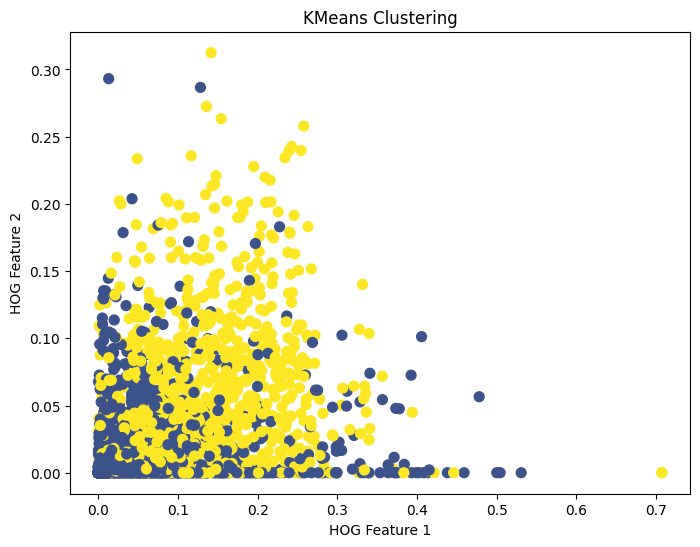

KMeans Cluster Mapping: {np.int32(1): ['100080576_f52e8ee070_n.jpg', '10043234166_e6dd915111_n.jpg', '1008566138_6927679c8a.jpg', '10090824183_d02c613f10_m.jpg', '100930342_92e8746431_n.jpg', '10128546863_8de70c610d.jpg', '10140303196_b88d3d6cec.jpg', '10172567486_2748826a8b.jpg', '10200780773_c6051a7d71_n.jpg', '1022552002_2b93faf9e7_n.jpg', '102501987_3cdb8e5394_n.jpg', '102841525_bd6628ae3c.jpg', '10294487385_92a0676c7d_m.jpg', '1031799732_e7f4008c03.jpg', '10386540106_1431e73086_m.jpg', '10386540696_0a95ee53a8_n.jpg', '10391248763_1d16681106_n.jpg', '1043442695_4556c4c13d_n.jpg', '10437652486_aa86c14985.jpg', '10437754174_22ec990b77_m.jpg', '10437770546_8bb6f7bdd3_m.jpg', '10437929963_bc13eebe0c.jpg', '1044296388_912143e1d4.jpg', '10466558316_a7198b87e2.jpg', '10486992895_20b344ce2d_n.jpg', '10503217854_e66a804309.jpg', '10555749515_13a12a026e.jpg', '10555815624_dc211569b0.jpg', '10559679065_50d2b16f6d.jpg', '105806915_a9c13e2106_n.jpg', '10683189_bd6e371b97.jpg', '10686568196_b191

In [1]:
import os
import shutil
import numpy as np
import matplotlib.pyplot as plt
from skimage import io, color
from skimage.feature import hog
from sklearn.cluster import MiniBatchKMeans  # MiniBatchKMeans for faster clustering
from sklearn.metrics import silhouette_score
from concurrent.futures import ThreadPoolExecutor
import time

# Set the correct path to the extracted folder
image_folder_path = 'flowers'  # Path where your images are located after extraction

# Function to load and preprocess images using HOG (Histogram of Oriented Gradients)
def load_and_preprocess_images(image_folder_path, batch_size=32):
    image_features = []  # List to hold the flattened feature vectors for each image
    image_filenames = []

    batch = []
    for image_filename in os.listdir(image_folder_path):
        img_path = os.path.join(image_folder_path, image_filename)
        
        if not img_path.lower().endswith(('png', 'jpg', 'jpeg')):
            continue  # Skip non-image files

        try:
            # Load image and resize it to a smaller size (128x128) for faster processing
            img = io.imread(img_path)
            img_resized = np.resize(img, (128, 128, 3))  # Resize for faster processing
            
            # Convert image to grayscale
            img_gray = color.rgb2gray(img_resized)

            # Compute HOG features
            fd, hog_image = hog(img_gray, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
            image_features.append(fd)  # Flattened HOG features
            image_filenames.append(image_filename)
        
        except Exception as e:
            print(f"Error processing image {image_filename}: {e}")

    # Convert the list of features into a 2D array where each row is a feature vector of an image
    image_features = np.array(image_features)

    if image_features.size == 0:
        raise ValueError("No features extracted from images. Please check the image files.")
    
    return image_features, image_filenames

# Load images and extract features with timing
start_time = time.time()
try:
    image_features, image_filenames = load_and_preprocess_images(image_folder_path)
    print(f"Loaded {len(image_filenames)} images and extracted features.")
    print(f"Feature extraction took {time.time() - start_time:.2f} seconds.")
except ValueError as e:
    print(e)
    image_features, image_filenames = [], []

# Check if image_features is empty or has the correct shape
if len(image_features) == 0:
    raise ValueError("No features extracted. Please check the images in the folder.")

# If shape is not 2D, ensure it's in the correct shape (2D array with rows as images and columns as features)
if len(image_features.shape) == 1:
    image_features = image_features.reshape(1, -1)  # Reshape if there's a single feature (single image case)

# Check the shape of the image_features to ensure it's 2D
print(f"Shape of image_features: {image_features.shape}")

# Scale the features (StandardScaler expects 2D array)
# You can skip scaling if you use simple features like HOG, as they are already normalized
scaled_features = image_features

# Apply MiniBatchKMeans clustering for faster processing
kmeans = MiniBatchKMeans(n_clusters=5, batch_size=10)
kmeans_labels = kmeans.fit_predict(scaled_features)

# Evaluate clustering with silhouette score
silhouette_avg = silhouette_score(scaled_features, kmeans_labels)
print(f"Silhouette Score: {silhouette_avg}")

# Function to visualize clusters
def visualize_clusters(features, cluster_labels, title="Cluster Visualization"):
    plt.figure(figsize=(8, 6))
    plt.scatter(features[:, 0], features[:, 1], c=cluster_labels, cmap='viridis', s=50)
    plt.title(title)
    plt.xlabel('HOG Feature 1')
    plt.ylabel('HOG Feature 2')
    plt.show()

# Visualize the clusters (if there are 2 dimensions, which for HOG is often possible)
visualize_clusters(scaled_features, kmeans_labels, title="KMeans Clustering")

# Create a dictionary to map cluster IDs to image filenames
def create_cluster_mapping(cluster_labels, image_filenames):
    cluster_mapping = {}
    for i, label in enumerate(cluster_labels):
        if label not in cluster_mapping:
            cluster_mapping[label] = []
        cluster_mapping[label].append(image_filenames[i])
    return cluster_mapping

# Create cluster mappings for KMeans clustering
kmeans_mapping = create_cluster_mapping(kmeans_labels, image_filenames)

# Print example cluster mappings
print("KMeans Cluster Mapping:", kmeans_mapping)

# Function to move a single image (using shutil for faster file movement)
def move_image(src_path, dest_path):
    shutil.move(src_path, dest_path)

# Function to move all images based on clusters using multi-threading
def move_images_parallel(cluster_mapping, output_folder):
    with ThreadPoolExecutor(max_workers=4) as executor:  # Adjust 'max_workers' for your system's capability
        futures = []
        for cluster_id, image_list in cluster_mapping.items():
            cluster_folder = os.path.join(output_folder, f'cluster_{cluster_id}')
            os.makedirs(cluster_folder, exist_ok=True)
            for img_filename in image_list:
                src_path = os.path.join(image_folder_path, img_filename)
                dest_path = os.path.join(cluster_folder, img_filename)
                futures.append(executor.submit(move_image, src_path, dest_path))
        
        # Wait for all tasks to complete
        for future in futures:
            future.result()

# Set output folder for clustering results
output_folder = 'output_clusters'

# Move images based on KMeans clustering using parallel processing
move_images_parallel(kmeans_mapping, output_folder)
print(f"Images moved to {output_folder}")
